In [1]:
from dataset import DataLoader, DataVisualizer, DatasetBuilder
#from models import *
import tensorflow as tf
from utils.input import *

2023-06-12 09:29:40.711449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 09:29:40.754439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-12 09:29:40.754478: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-12 09:29:40.754495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-12 09:29:40.762815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 09:29:40.763555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data = DataLoader(path='DATA/speech_commands_v0.02')

Dataset path:  DATA/speech_commands_v0.02


In [3]:
commands = data.get_commands()
commands

array(['eight', 'sheila', 'nine', 'yes', 'one', 'no', 'left', 'tree',
       'bed', 'bird', 'go', 'wow', 'seven', 'marvin', 'dog', 'three',
       'two', 'house', 'backward', 'down', 'six', 'five', 'off', 'right',
       'cat', 'zero', 'four', 'forward', 'stop', 'up', 'visual', 'learn',
       'on', 'happy', 'follow'], dtype='<U19')

In [4]:
filenames = data.get_filenames()

In [5]:
train_files, val_files, test_files = data.split_data(filenames)

2023-06-12 09:29:43.831316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 09:29:43.870258: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1958] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
val_files

<tf.Tensor: shape=(5291,), dtype=string, numpy=
array([b'DATA/speech_commands_v0.02/cat/cc8b3228_nohash_0.wav',
       b'DATA/speech_commands_v0.02/three/6a014b29_nohash_0.wav',
       b'DATA/speech_commands_v0.02/no/879a2b38_nohash_0.wav', ...,
       b'DATA/speech_commands_v0.02/cat/78102205_nohash_1.wav',
       b'DATA/speech_commands_v0.02/up/0132a06d_nohash_1.wav',
       b'DATA/speech_commands_v0.02/bird/106a6183_nohash_0.wav'],
      dtype=object)>

In [7]:
commands

array(['eight', 'sheila', 'nine', 'yes', 'one', 'no', 'left', 'tree',
       'bed', 'bird', 'go', 'wow', 'seven', 'marvin', 'dog', 'three',
       'two', 'house', 'backward', 'down', 'six', 'five', 'off', 'right',
       'cat', 'zero', 'four', 'forward', 'stop', 'up', 'visual', 'learn',
       'on', 'happy', 'follow'], dtype='<U19')

In [8]:
data.get_waveform_ds(test_files)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
ds = DatasetBuilder(
    commands=commands,
    train_filenames=train_files,
    val_filenames=val_files,
    test_filenames=test_files,
    batch_size=64,
    buffer_size=1000,
    method='STFT',
)


In [10]:
ds

In [11]:
train, test, val = ds.preprocess_dataset_spectrogram()

In [12]:
train_waveforms = data.get_waveform_ds(train_files)

In [13]:
for waveform, label in train_waveforms.take(1):
  print("Waveform shape: ", waveform.numpy().shape)
  print("Label: ", label.numpy())
  prova = waveform.numpy()

Waveform shape:  (16000,)
Label:  b'up'


In [14]:
# Take only the first 5 elements
subset_dataset = train_waveforms.take(1)

subset_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [15]:
train_waveforms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [26]:
import tensorflow as tf
import librosa

# Define augmentation parameters
time_stretch_range = (0.8, 1.2)
pitch_shift_range = (-2, 2)

# Augmentation functions
def time_stretch_augmentation(waveform):
    rate = tf.random.uniform([], *time_stretch_range)
    def apply_time_stretch(waveform, rate):
        return librosa.effects.time_stretch(waveform.copy(), rate=rate)
    return tf.numpy_function(apply_time_stretch, [waveform, rate], tf.float32)

def pitch_shift_augmentation(waveform):
    n_steps = tf.random.uniform([], *pitch_shift_range)
    def apply_pitch_shift(waveform, n_steps):
        return librosa.effects.pitch_shift(waveform.copy(), 44100, n_steps)
    return tf.numpy_function(librosa.effects.pitch_shift, [waveform, 44100, n_steps], tf.float32)

# Apply augmentation to your dataset
stretch = train_waveforms.map(lambda waveform, label:
                                     (time_stretch_augmentation(waveform), label))
pitch = train_waveforms.map(lambda waveform, label:
                                          (pitch_shift_augmentation(waveform), label))


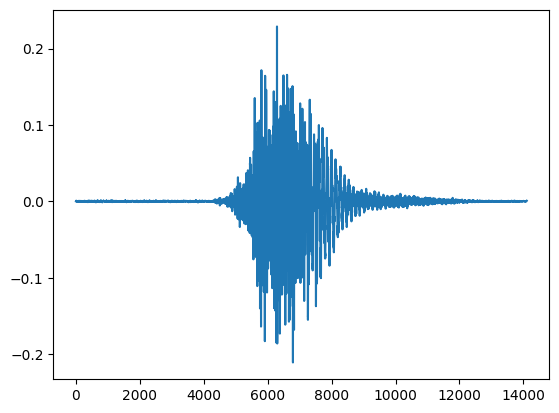

In [29]:
import matplotlib.pyplot as plt

for i, (waveform, label) in enumerate(stretch.take(1)):
    plt.plot(waveform.numpy())

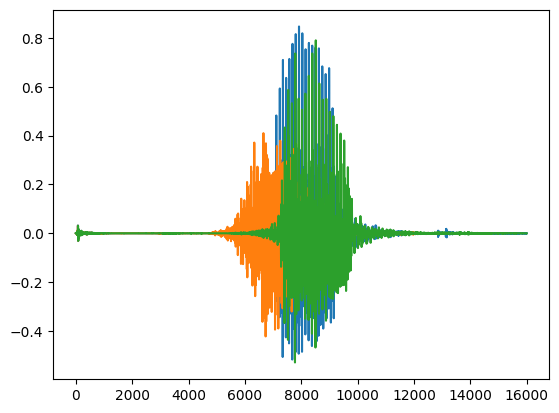

In [18]:
from utils.augment import pitch_shift, time_stretch
import matplotlib.pyplot as plt
time_stretched = train_waveforms.map(
    lambda waveform, label: (time_stretch(waveform), label)
)
pitch_shifted = train_waveforms.map(
    lambda waveform, label: (pitch_shift(waveform), label)
)

for waveform, label in train_waveforms.take(1):
    plt.plot(waveform.numpy())
    

for waveform, label in time_stretched.take(1):
    plt.plot(waveform.numpy())
    
for waveform, label in pitch_shifted.take(1):
    plt.plot(waveform.numpy())

In [16]:

import librosa
import numpy as np


# Function to apply time warp to waveform
def pitch_shift_map(waveform, label):
    # Apply time_warp to waveform
    waveform = pitch_shift(waveform)

    # Return the warped waveform and original label
    return waveform, label

def time_stretch_map(waveform, label):
    # Apply time_warp to waveform
    waveform = time_stretch(waveform)

    # Return the warped waveform and original label
    return waveform, label

stretch_waveforms = train_waveforms.map(time_stretch_map)
pitch_waveforms = train_waveforms.map(pitch_shift_map)

In [17]:
for waveform, label in pitch_waveforms.take(1):
    print("Waveform shape: ", waveform.numpy().shape)
    print("Label: ", label.numpy())

<class 'numpy.ndarray'>
Waveform shape:  (16000,)
Label:  b'three'


In [19]:
for waveform, label in stretch_waveforms.take(1):
    print("Waveform shape: ", waveform.numpy().shape)
    print("Label: ", label.numpy())

2023-06-11 23:28:14.914759: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filed5m5ziw

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filed5m5ziwa.py", line 31, in apply_time_stretch
    stretched_audio = ag__.converted_call(ag__.ld(librosa).effects.time_stretch, (ag__.converted_call(ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1).copy, (), None, fscope_1),), dict(rate=ag__.ld(rate)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 740, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 256, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      


	 [[{{function_node __inference_time_stretch_632}}{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def apply_time_stretch(audio, rate):
    stretched_audio = librosa.effects.time_stretch(
        audio.numpy(),
        rate=rate
    )
    print(type(stretched_audio))
    return stretched_audio.astype(np.float32)

@tf.function
def time_stretch(
    audio,
    rate=.5
):
    """
    Apply time stretching to audio
    
    Parameters
    ----------
    audio : tf.Tensor
        Audio to apply time stretching to
    rate : float, optional
        Rate to stretch audio by, by default 1.0
    
    Returns
    -------
    tf.Tensor
        Stretched audio
    """
    return tf.py_function(
        apply_time_stretch,
        [audio, rate],
        tf.float32
    )

Waveform shape:  (16000,)
Label:  b'off'
<class 'numpy.ndarray'>


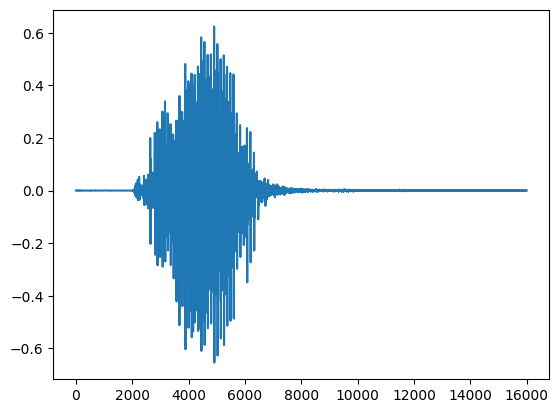

In [22]:
for waveform, label in train_waveforms.take(1):
    print("Waveform shape: ", waveform.numpy().shape)
    print("Label: ", label.numpy())
stretch_waveform = apply_time_stretch(waveform, rate=.5)
plt.figure()
plt.plot(waveform.numpy())

In [33]:
for waveform, label in prova_waveforms.take(1):
  print("Waveform shape: ", waveform.numpy().shape)
  print("Label: ", label.numpy())

2023-06-11 22:33:47.625089: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filecbso6il

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filecbso6ilk.py", line 31, in apply_time_stretch
    stretched_audio = ag__.converted_call(ag__.ld(librosa).effects.time_stretch, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(rate=ag__.ld(rate)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 740, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 256, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      


	 [[{{function_node __inference_prova_1150}}{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

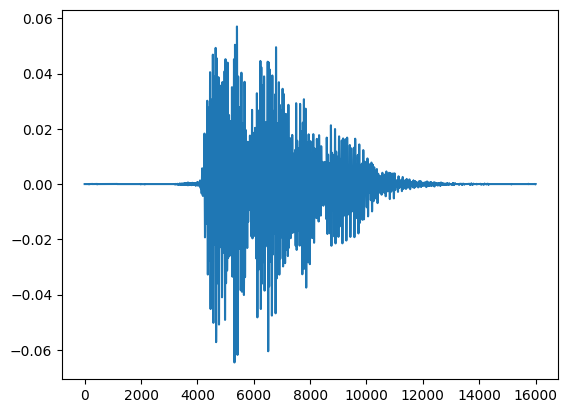

In [24]:
import matplotlib.pyplot as plt
for i, (waveform, label) in enumerate(train_waveforms.take(1)):
    plt.plot(waveform.numpy())

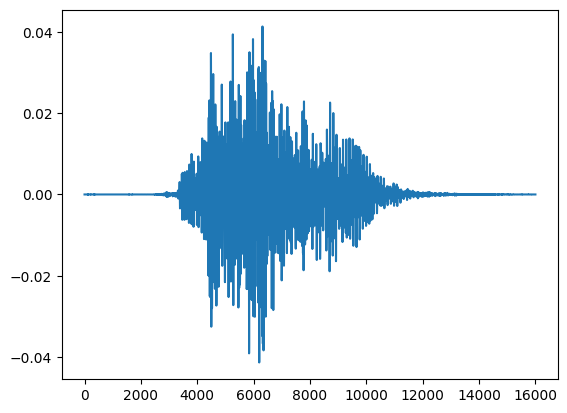

In [25]:
for i, (waveform, label) in enumerate(pitch_waveforms.take(1)):
    plt.plot(waveform.numpy())

In [26]:
for i, (waveform, label) in enumerate(prova_waveforms.take(1)):
    plt.plot(waveform.numpy())

2023-06-11 19:54:20.752309: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filefvt3qxc

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filefvt3qxcx.py", line 31, in apply_time_stretch
    stretched_audio = ag__.converted_call(ag__.ld(librosa).effects.time_stretch, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(rate=ag__.ld(rate)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 740, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 256, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      


	 [[{{function_node __inference_prova_1019}}{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

2023-06-11 19:54:20.820935: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filefvt3qxc

In [17]:
for i, (waveform, label) in enumerate(pitch_waveforms.take(1)):
    print("Augmented waveform shape: ", waveform.numpy().shape)
    print("Augmented label: ", label.numpy())


Augmented waveform shape:  (16000,)
Augmented label:  b'visual'


In [32]:
pitch_shift(waveform)

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 3.1698710e-06,  3.4838893e-05,  6.9416637e-05, ...,
        3.2330945e-08, -2.4784589e-05, -3.7856360e-05], dtype=float32)>

In [39]:
def apply_pitch_shift(audio, n_steps):
    return librosa.effects.pitch_shift(
        audio.numpy(),
        sr=22050,
        n_steps=n_steps
    )
type(apply_pitch_shift(waveform, 4))

numpy.ndarray

In [40]:
def apply_time_stretch(audio, rate):
    return librosa.effects.time_stretch(
        audio.numpy(),
        rate=rate
    )
    
type(apply_time_stretch(waveform, 0.8))

numpy.ndarray

In [37]:
def apply_time_stretch(audio, rate):
    stretched_audio = librosa.effects.time_stretch(
        audio.numpy(),
        rate=rate
    )
    return stretched_audio.astype(np.float32)

In [31]:
tf.py_function(
    apply_time_stretch,
    [waveform, .2],
    tf.float32
)


2023-06-11 19:37:44.927421: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_322022/3522518992.py", 

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_2_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_322022/3522518992.py", line 2, in apply_time_stretch
    stretched_audio = librosa.effects.time_stretch(

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 740, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 256, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

 [Op:EagerPyFunc] name: 

In [28]:
for i, (waveform, label) in enumerate(train_waveforms.take(1)):
    res = apply_time_stretch(waveform, .2)

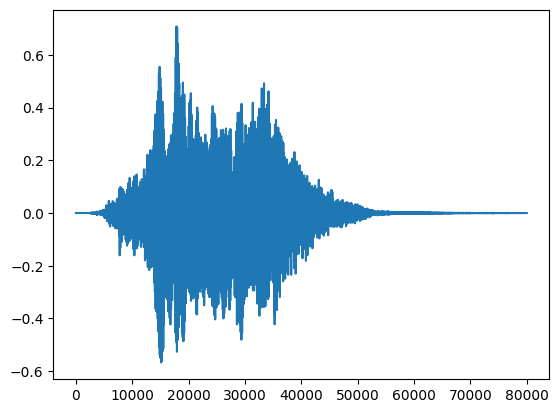

In [29]:
import matplotlib.pyplot as plt
plt.plot(res)

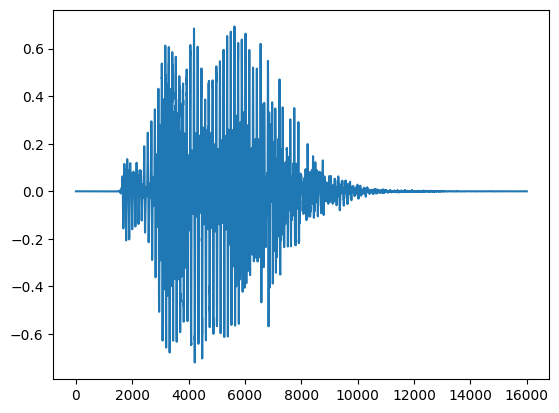

In [27]:
plt.plot(waveform.numpy())

In [18]:
for i, (waveform, label) in enumerate(stretch_waveforms.take(1)):
    print("Augmented waveform shape: ", waveform.numpy().shape)
    print("Augmented label: ", label.numpy())


2023-06-11 19:33:27.244858: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filezd8ri45

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filezd8ri45a.py", line 31, in apply_time_stretch
    stretched_audio = ag__.converted_call(ag__.ld(librosa).effects.time_stretch, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(rate=ag__.ld(rate)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 740, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 256, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      


	 [[{{function_node __inference_time_stretch_922}}{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [19]:
from IPython import display

for waveform, label in train_waveforms.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))

for waveform, label in pitch_shifted.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))
    
for waveform, label in time_stretched.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))

In [15]:
from IPython import display

for waveform, label in stretch_waveforms.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))
        

2023-06-11 14:34:51.335501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-11 14:34:51.472736: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    o

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_file1sizn6xc.py", line 31, in apply_time_stretch
    stretched_audio = ag__.converted_call(ag__.ld(librosa).effects.time_stretch, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(rate=ag__.ld(rate)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 253, in time_stretch
    len_stretch = int(round(y.shape[-1] / rate))

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/numpy_ops/np_array_ops.py", line 738, in around
    return a.astype(dtype)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 437, in __getattr__
    raise AttributeError(

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      


	 [[{{function_node __inference_time_stretch_848}}{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [20]:
for waveform, label in train_waveforms.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))
        

2023-06-07 22:48:57.675314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [27]:
def time_freq_mask_map(spec, label):
    # Apply time_warp to waveform
    masked_spec = time_freq_mask(spec)
    print(masked_spec.shape)
    print(label)

    # Return the warped waveform and original label
    return masked_spec, label

In [20]:
spectrograms = data.get_spectrogram_STFT_ds(
    train_waveforms,
    commands
)

for spec, label in spectrograms.take(1):
    print("Spectrogram shape: ", spec.numpy().shape)
    print("Label: ", label.numpy())
    prova = spec.numpy()

Spectrogram shape:  (257, 98, 1)
Label:  15


In [ ]:
spec

(257, 98, 1)


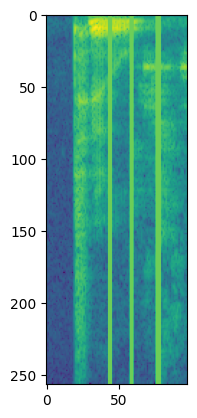

In [36]:
def apply_time_mask(
        spec,
        num_masks=4,
        mask_factor=4
    ):
        masked_spec = spec.copy()
        print(masked_spec.shape)
        _, time_frames, _ = masked_spec.shape
        n_masks = tf.random.uniform(
            shape=[],
            minval=1,
            maxval=num_masks+1,
            dtype=tf.int32
        )
        for _ in range(n_masks):
            t = tf.random.uniform(
                shape=[],
                minval=0,
                maxval=time_frames,
                dtype=tf.int32
            )
            t_mask = tf.random.uniform(
                shape=[],
                minval=1,
                maxval=mask_factor+1,
                dtype=tf.int32
            )
            masked_spec[:, t:t + t_mask, :] = 0
        return masked_spec

plt.imshow(apply_time_mask(prova)[:,:,0])

In [23]:
from utils.augment import time_freq_mask

def time_freq_mask_map(spec, label):
    # Apply time_warp to waveform
    masked_spec = time_freq_mask(spec)
    print(masked_spec.shape)
    print(label)

    # Return the warped waveform and original label
    return masked_spec, label

masked_spectrograms = spectrograms.map(time_freq_mask_map)

for i, (spec, label) in enumerate(masked_spectrograms.take(1)):
    #print("Augmented spectrogram shape: ", spec.numpy().shape)
    print("Augmented label: ", label.numpy())

<unknown>
Tensor("args_1:0", shape=(), dtype=int64)


2023-06-11 23:22:09.282146: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_file1k0_33yf.py", line 16, in apply_time_freq_mask
    masked_spec = ag__.converted_call(ag__.ld(spec).copy, (), None, fscope_1)

  Fil

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_file1k0_33yf.py", line 16, in apply_time_freq_mask
    masked_spec = ag__.converted_call(ag__.ld(spec).copy, (), None, fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/tensor.py", line 261, in __getattr__
    self.__getattribute__(name)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'


	 [[{{function_node __inference_time_freq_mask_1147}}{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

2023-06-07 22:50:22.898739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-07 22:50:22.899514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-07 22:50:23.046092: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", 

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_fileyzxlwqyk.py", line 16, in apply_time_freq_mask
    masked_spec = ag__.converted_call(ag__.ld(spec).copy, (), None, fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 443, in __getattr__
    self.__getattribute__(name)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'copy'


	 [[{{function_node __inference_time_freq_mask_1170}}{{node EagerPyFunc}}]] [Op:IteratorGetNext]

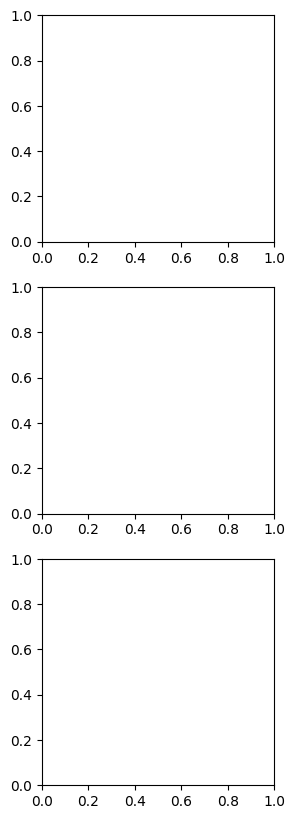

In [24]:
visual = DataVisualizer(pitch_waveforms, masked_spectrograms, commands)
visual.plot_spectrogram_example(rows=3, cols=1, figsize=(3,10), savefig=True, filename='spectrogram_example.pdf')


In [14]:
for spectrogram, _ in spectrograms.take(1):
    print(spectrogram.numpy().shape)
    print(visual.commands[_.numpy()])

(257, 98, 1)
stop


2023-06-07 21:40:55.760011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-07 21:40:55.760536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [15]:
train_spectrograms = data.get_spectrogram_logmel_ds(
    train_waveforms,
    commands
)
train_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(40, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
mfcc_spectrograms = data.get_spectrogram_mfcc_ds(
    train_waveforms,
    commands
)
mfcc_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(13, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())

2023-06-07 21:40:57.470779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-07 21:40:57.472248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  (40, 98)
Label:  28


In [18]:
from dataset import DataVisualizer
visual = DataVisualizer(train_waveforms, train_spectrograms, commands)

In [19]:
for i, (audio, label) in enumerate(pitch_waveforms.take(1)):
  print('Audio shape: ', audio.numpy().shape)
  print('Label: ', label.numpy())

2023-06-07 22:31:45.097372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-07 22:31:53.203646: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: could not convert string to float: b'stop'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/h

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: could not convert string to float: b'stop'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_file88or8aeh.py", line 31, in apply_pitch_shift
    shifted_audio = ag__.converted_call(ag__.ld(librosa).effects.pitch_shift, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(sr=22050, n_steps=ag__.ld(n_steps)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 332, in pitch_shift
    rate = 2.0 ** (-float(n_steps) / bins_per_octave)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1065, in __float__
    return float(self._numpy())

ValueError: could not convert string to float: b'stop'


	 [[{{function_node __inference_pitch_shift_807}}{{node EagerPyFunc}}]] [Op:IteratorGetNext]

2023-06-06 22:40:59.294365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-06 22:41:04.975794: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: could not convert string to float: b'cat'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/ho

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: could not convert string to float: b'cat'
Traceback (most recent call last):

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_file3y22dgov.py", line 31, in apply_pitch_shift
    shifted_audio = ag__.converted_call(ag__.ld(librosa).effects.pitch_shift, (ag__.converted_call(ag__.ld(audio).numpy, (), None, fscope_1),), dict(sr=22050, n_steps=ag__.ld(n_steps)), fscope_1)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/librosa/effects.py", line 332, in pitch_shift
    rate = 2.0 ** (-float(n_steps) / bins_per_octave)

  File "/home/aidina/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1065, in __float__
    return float(self._numpy())

ValueError: could not convert string to float: b'cat'


	 [[{{function_node __inference_pitch_shift_807}}{{node EagerPyFunc}}]] [Op:IteratorGetNext]

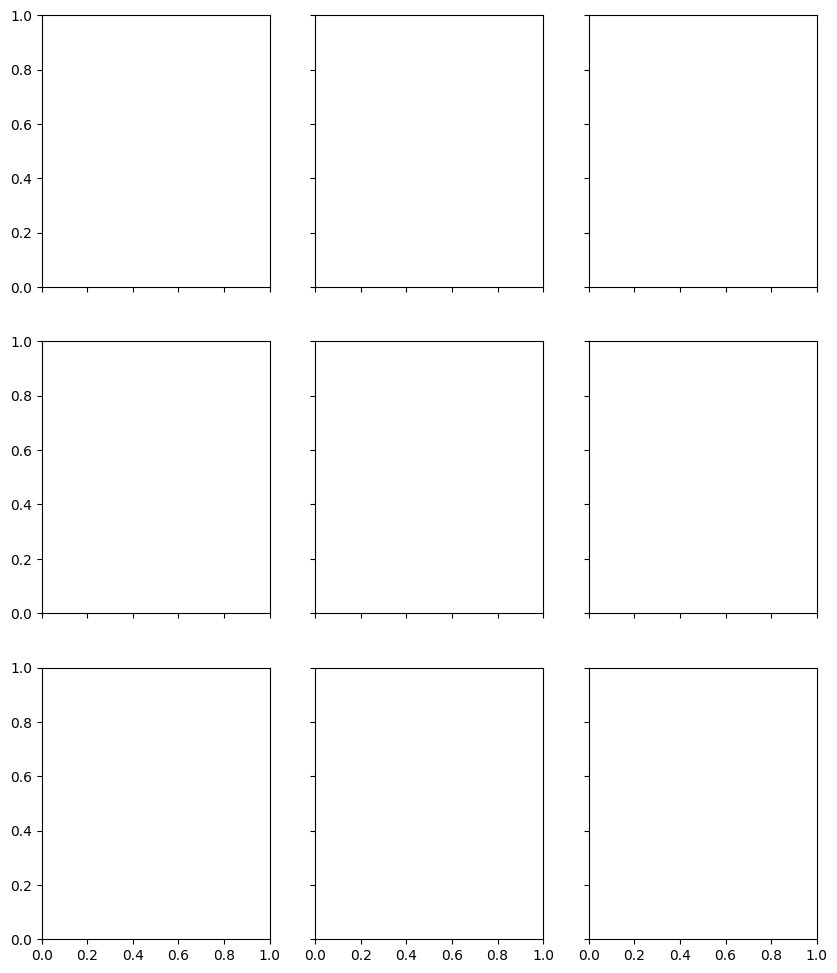

In [19]:
visual.plot_waveform_example()

In [19]:
visual.listen_waveform(save=True)

Label: no
Waveform shape: (16000,)
Spectrogram shape: (257, 98, 1)
Audio playback


2023-06-04 12:09:08.549409: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


2023-06-04 12:09:08.791675: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 12:09:08.791777: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


(40, 98)
(40, 98)
(40, 98)
(40, 98)
(40, 98)
(40, 98)
(40, 98)
(40, 98)
(40, 98)


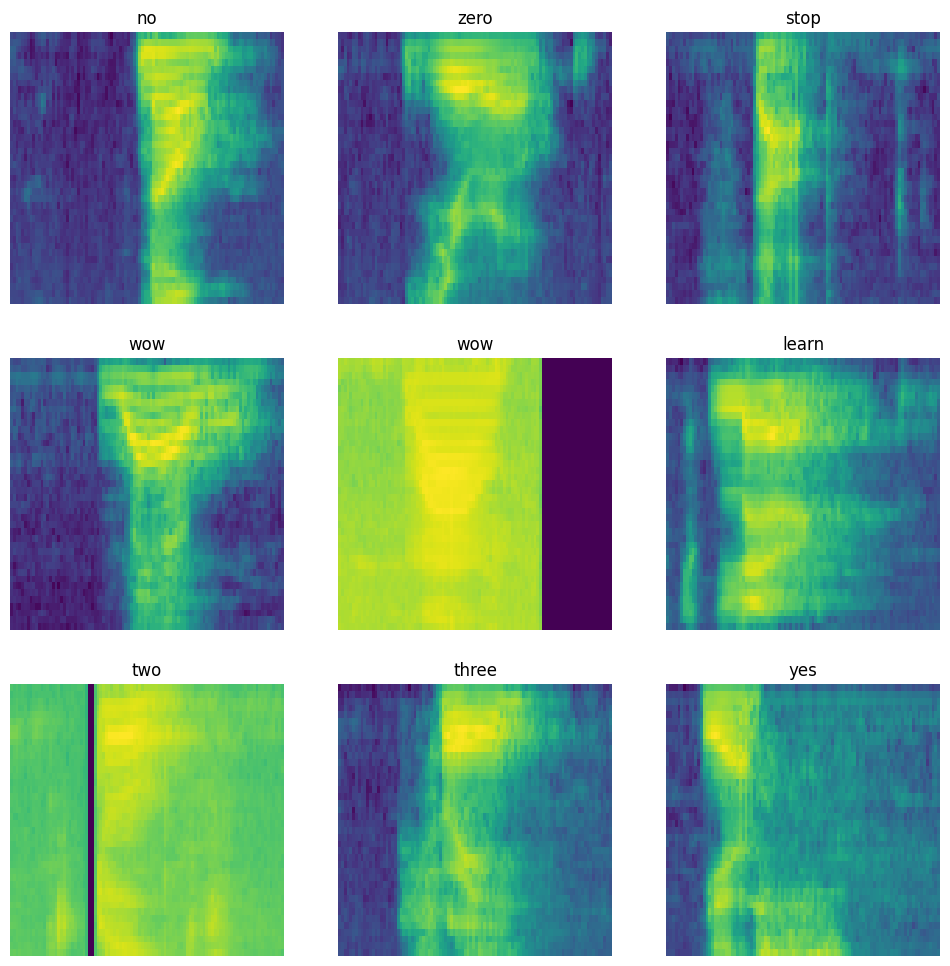

In [20]:
visual.plot_spectrogram_example()

In [21]:
from utils.plot import plot_features

2023-06-04 12:09:09.692552: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 12:09:09.692650: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  (40, 98)
Label:  no


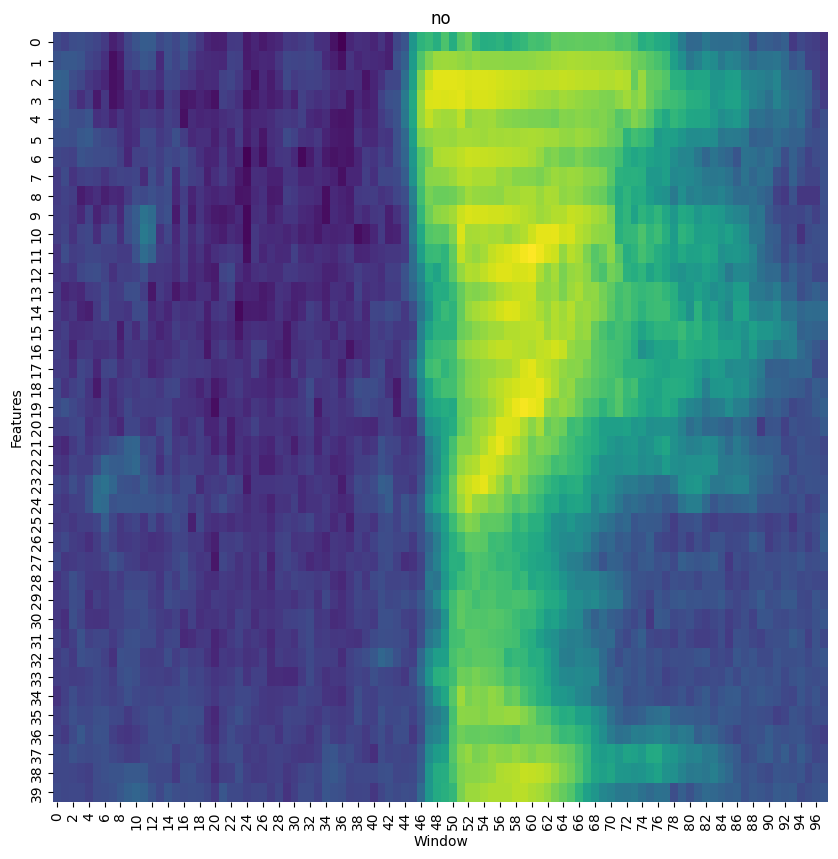

In [22]:
import matplotlib.pyplot as plt

for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  axes.set_title(visual.commands[label.numpy()])

2023-06-04 12:09:10.092336: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 12:09:10.092442: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  (13, 98)
Label:  no


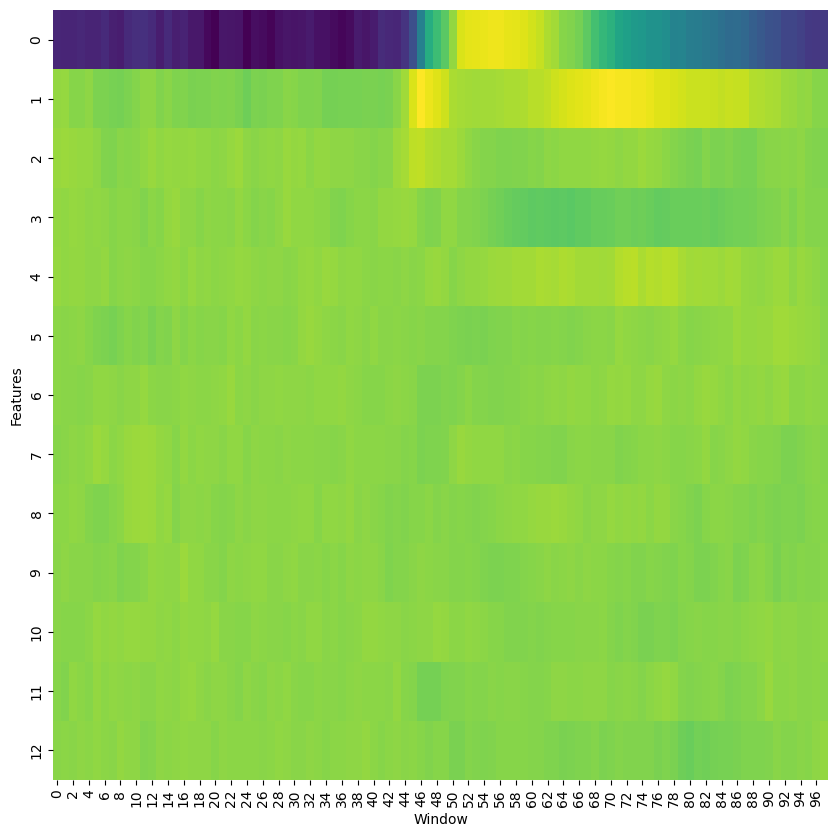

In [23]:
import matplotlib.pyplot as plt
import numpy as np

for i, (spectrogram, label) in enumerate(mfcc_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  plt.show()

2023-06-04 12:09:10.412699: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 12:09:10.412891: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  (257, 98, 1)
Label:  10


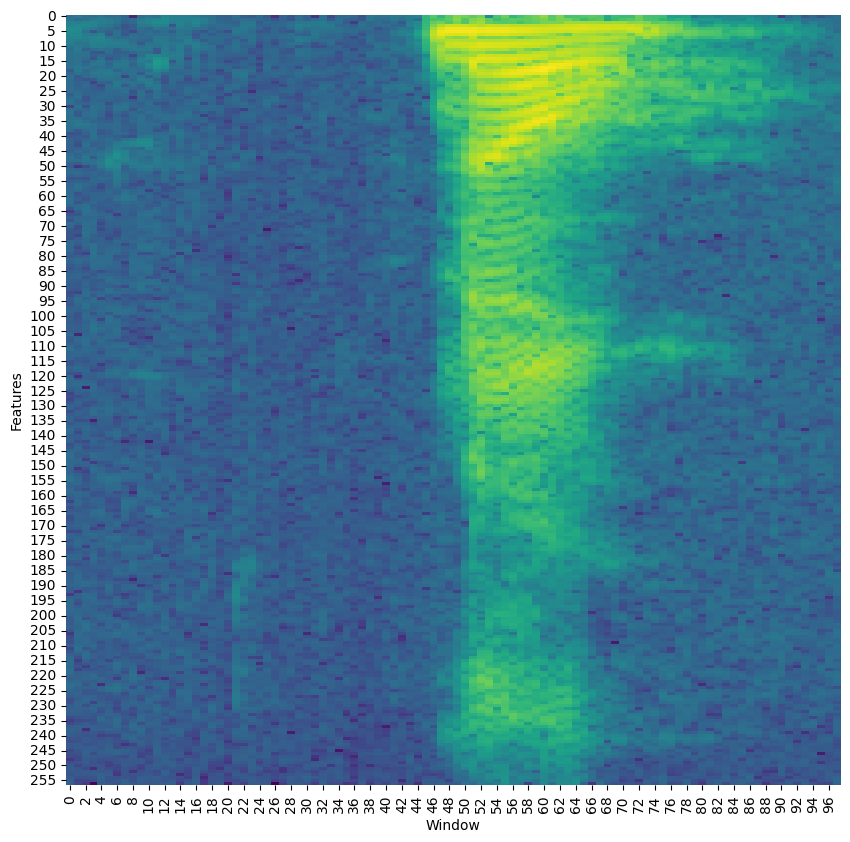

In [24]:
for i, (spectrogram, label) in enumerate(spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [25]:
for i, (spectrogram_batch, label_batch) in enumerate(train.take(1)):
    for spectrogram in spectrogram_batch:
        spectrogram_shape = tf.shape(spectrogram)
        print("Spectrogram shape:", spectrogram_shape)


2023-06-04 12:09:10.755452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 12:09:10.755636: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], sha

2023-06-04 12:09:11.063879: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [30]:
from models import CNNTradFPool3

model = CNNTradFPool3(
    train_ds = train,
    test_ds = test,
    val_ds = val,
    commands = commands,
)
model.define_model()
model.model.summary()

2023-06-04 14:56:45.115251: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 14:56:45.115919: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-04 14:56:45.505390: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input p

ValueError: Exception encountered when calling layer "resizing" (type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing" (type Resizing):
  • inputs=tf.Tensor(shape=(None, 257, 98, 1, 1), dtype=float32)

In [ ]:
model.create_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 98)]          0         
                                                                 
 resizing_1 (Resizing)       (32, 32, 98)              0         
                                                                 
 normalization (Normalizati  (32, 32, 98)              3         
 on)                                                             
                                                                 
 tf.expand_dims_1 (TFOpLamb  (32, 32, 98, 1)           0         
 da)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 32, 98, 64)          10304     
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 32, 32, 64)          0   

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import tensorboard

In [ ]:
name_model = 'CNNTradFPool3'

In [ ]:
model_tensorboad_callback = TensorBoard(log_dir="logs/{}".format(name_model))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
history = model.fit(
    epochs=10,
    callbacks=[model_checkpoint_callback],
    verbose=1,
    return_history=True,)

Epoch 1/10


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1364, in train_function  *
        return step_function(self, iterator)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1348, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1329, in run_step  **
        outputs = model.train_step(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1106, in train_step
        y_pred = self(x, training=True)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_1' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_1' (type Resizing):
      • inputs=tf.Tensor(shape=(40, None), dtype=float32)


In [ ]:
model.input_shape

TensorShape([40, 98])

Spectrogram shape:  (40, 98)
Label:  ()


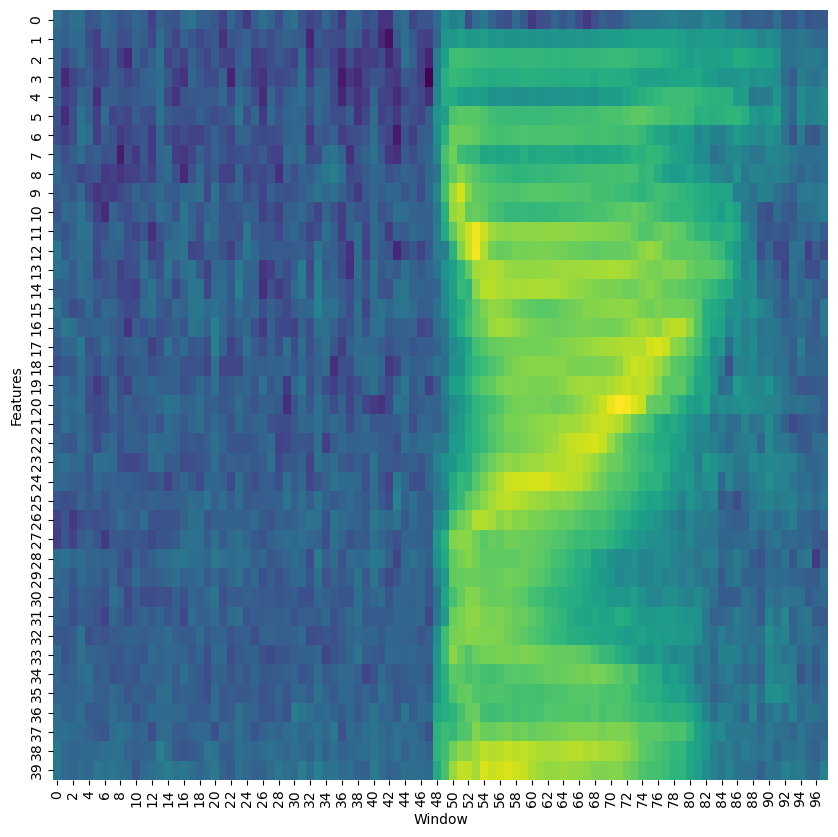

In [ ]:
for i, (spectrogram, label) in enumerate(model.train_ds.take(1)):
  print('Spectrogram shape: ', spectrogram.shape)
  print('Label: ', label.shape)
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [ ]:
model.input_shape

TensorShape([40, 98])

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,\
                                    Flatten, Dense, Input,\
                                    Resizing

input = Input(model.input_shape)

In [ ]:
a = Resizing(32,32)(input)
a = model.norm_layer(a)

In [ ]:
a = tf.expand_dims(a, -1)
a

<KerasTensor: shape=(32, 32, 98, 1) dtype=float32 (created by layer 'tf.expand_dims_2')>

In [ ]:
Conv2D(
    filters=64,
    kernel_size=(20,8),
    activation='relu',
    padding='same',
)(a)

<KerasTensor: shape=(32, 32, 98, 64) dtype=float32 (created by layer 'conv2d_4')>

In [ ]:
a

<KerasTensor: shape=(32, 3136) dtype=float32 (created by layer 'flatten_1')>

In [ ]:
#norm_layer = tf.keras.layers.Normalization(axis=-1)
#
#dummy_input = tf.keras.Input(shape=model.input_shape[1:], name='Input')
#norm_layer.adapt(dummy_input)
#norm_layer

batch_size = 64

norm_layer = tf.keras.layers.Normalization(axis=-1)
# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
dummy_input = tf.zeros(shape=(batch_size,) + model.input_shape[1:])
norm=norm_layer.adapt(data=dummy_input)

norm(tf.zeros(shape=(batch_size,) + model.input_shape[1:]))

TypeError: 'NoneType' object is not callable

In [ ]:
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

2023-06-02 22:39:00.269047: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:39:00.269261: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 295, in _adapt_maybe_build  **
        self.build(data_shape)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/layers/preprocessing/normalization.py", line 188, in build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [40, None], with unknown axis at index: 1


In [ ]:
for spec in train.map(
    map_func = lambda spec, label: spec
).take(1): print(tf.keras.layers.Normalization())

2023-06-02 22:27:41.555767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:27:41.556127: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [ ]:
tf.__version__

'2.14.0-dev20230523'

In [ ]:
adapt_data = np.array([1., 2., 3., 4., 5.], dtype='float32')
input_data = np.array([1., 2., 3.], dtype='float32')
layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(adapt_data)
layer(input_data)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4142135 , -0.70710677,  0.        ], dtype=float32)>

In [ ]:
a = train.map(
    map_func = lambda spec, label: spec
)

layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(a)

2023-06-02 23:22:44.347962: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 23:22:44.348166: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [ ]:
layer()

In [ ]:
layer

In [ ]:
import tensorflow as tf

tf.keras.layers.Normalization().adapt(data)

2023-06-02 22:21:55.288832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.333223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-02 22:21:55.333253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-02 22:21:55.333269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-02 22:21:55.341841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.342528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

NameError: name 'data' is not defined

In [ ]:
for i, spectrogram in enumerate(data.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy())

2023-06-02 22:19:59.303902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:19:59.304737: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  [[-8.084161  -7.4094577 -8.041817  ... -6.5123463 -6.3396134 -6.848423 ]
 [-6.929613  -7.538925  -7.3320603 ... -5.643735  -6.306602  -6.2586904]
 [-6.761951  -7.407536  -6.6224604 ... -5.2255635 -6.1703243 -6.5690527]
 ...
 [-6.36265   -6.482527  -6.8747015 ... -6.046159  -5.95908   -6.1442876]
 [-6.192444  -6.344539  -5.924209  ... -5.9950767 -5.82529   -5.581264 ]
 [-5.9521194 -6.580887  -6.0298157 ... -5.451576  -5.346531  -5.882458 ]]


In [ ]:
norm_layer = tf.keras.layers.Normalization().adapt(spectrogram)